# Bivalves reveal that the North Atlantic destabilised before the onset of the Little Ice Age

In [2]:
%%bash 
cd ../../lib/regimeshifts
git checkout cfd140aef7dbeb4156bdf6cb2f7bbee3f0ada819

HEAD is now at cfd140a Tests the early warning indicators with the corresponding libraries in E


In [3]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import string
import sys
import xarray as xr
sys.path.append('../../lib')
from regimeshifts import ews

In [6]:
## The records are publicly available at https://www.ncei.noaa.gov/access/paleo-search/
rec_ids = {'GI':'NIS_PB_RCSars','d18O':'NIS_DR_d18O','d13C':'NIS_DR_d13C'}
series = []
data_path = 'data/bivalve_rec/'
md = pd.read_csv(data_path+'chronologies_metadata.csv',index_col=0) ## Records metadata 
for chron,rec_id in rec_ids.items():    
    df = pd.read_csv(data_path+md.loc[rec_id].file, comment='#', sep='\t', index_col=0) ## Reads the data-file for each record
    ts = df[md.loc[rec_id]['column_name']]
    ts.rename(chron,inplace=True)
    ts.index = ts.index.astype(int)
    ts.index.name = 'year_ce'
    series.append(ts.dropna())
records = pd.concat(series,axis=1,join='outer') ## Merges the series in a dataframe
records = ews.Ews(records[records.index>999]) ## Filters out the data prior to the year 1000 CE
longitude = (md.loc[rec_id]['Westernmost_lon']+md.loc[rec_id]['Easternmost_lon'])/2 ## Retrieves the coordinates of the sampling site
latitude = (md.loc[rec_id]['Northernmost_lat']+md.loc[rec_id]['Southernmost_lat'])/2

## Location of the bivalve proxy records sampling site

In [5]:
#NOAA ETOPO Global relief model https://www.ngdc.noaa.gov/mgg/global/global.html
img = plt.imread('../../../datasets/color_etopo1_ice_low.jpg') 
## April 2016 SST data from the European Space Agency (ESA)'s Climate Change Initiative (CCI) programme.
## https://dap.ceda.ac.uk/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/2016/04/
path = '../../../datasets/CCI_sst/'
cci_apr_f = '20160411120000-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_CDR2.0-v02.0-fv01.0.nc'
cci_sst_apr= xr.open_mfdataset(path+cci_apr_f,combine='by_coords')
cci_sst_apr = cci_sst_apr.assign(analysed_sst=cci_sst_apr.analysed_sst-273.15)

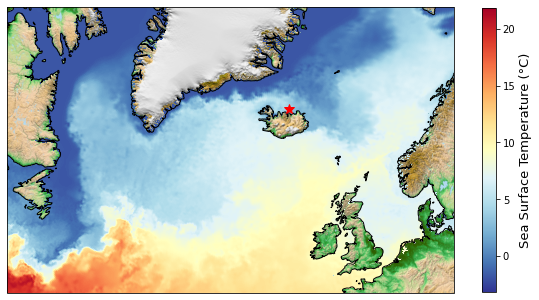

In [6]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection = ccrs.EquidistantConic(central_longitude=0.0, central_latitude=50.0, false_easting=20.0, false_northing=80.0, standard_parallels=(20.0, 50.0), globe=None))# create a set of axes with Mercator projection
ax.set_extent([-60.483, 12.64, 47.733,70.14]) 
ax.plot(longitude,latitude, '*', markersize=10,color='red', transform=ccrs.Geodetic())
ax.coastlines(resolution='50m')
ax.imshow(img, origin='upper', transform=ccrs.PlateCarree())
cmap = cci_sst_apr.analysed_sst.plot(ax=ax,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',vmin=-3.15,vmax=21.85,add_colorbar=False)
ax.set_title('');
cbar = fig.colorbar(cmap, ax=ax, shrink=0.87)
cbar.ax.set_ylabel(r'Sea Surface Temperature (°C)', fontsize=13);
#fig.savefig('img/NA_map_biv_site.png',dpi=300, bbox_inches='tight')

## Exploring changes in resilience (stability) over the last millennium

In [7]:
wL = 70 # window length (in years) for the initial exploratory analysis
bW = 40 # Detrending bandwidth
ar1 = records.ar1(detrend=True,bW=bW,wL=wL)
var_raw = records.var(detrend=True,bW=bW,wL=wL)
trends = records.gaussian_det(bW=bW).trend
var = (var_raw - var_raw.mean())/var_raw.std() ## Standardising variance

In [15]:
### Color codes and labels for the figures
rec_names = ['d18O','d13C','GI']
colors = {'d18O':'#377eb8','d13C':'tab:orange','GI':'#4daf4a'}
labels = {'d18O':r'$\delta ^{18}O$','d13C':r'$\delta ^{13}C$','GI':'Growth Index'}
episodes = {'1':[1110,1260],
            'int':[1190,1330],
            '2':[1260,1380]}
ep_names = {'1':'First Episode',
            'int':'Intermediate period',
            '2':'Second Episode'}
metrics = {'ar1':'AR(1)', 'var':'Variance'}
test_type = {'1':'positive',
            'int':'negative',
            '2':'positive'}

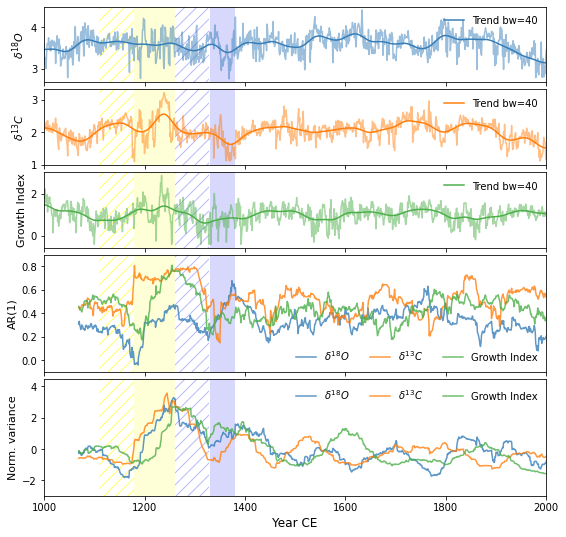

In [9]:
## Figure
fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(36, 14, hspace=1)

axes={}
for i,e in enumerate(rec_names):
    axes[e] = plt.subplot(gs[0+i*6:6*(i+1), 0:14]) ## Iceland records
axes['ar1'] = plt.subplot(gs[18:27,0:14]) # AR(1) trends
axes['var'] = plt.subplot(gs[27:36,0:14]) # Variance trends

for rec,ax in axes.items():
    ax.axvspan(episodes['1'][0]+wL, episodes['1'][1], color=(255/255,255/255,0,40/255), lw=0) ## Regions with potential loss of resilience
    ax.axvspan(episodes['2'][0]+wL, episodes['2'][1], color=(0/255,7/255,241/255,40/255), lw=0)
    ax.axvspan(episodes['1'][0], episodes['1'][0]+wL-1,hatch="//", facecolor="none",edgecolor=(255/255,255/255,0,150/255), lw=0)
    ax.axvspan(episodes['2'][0], episodes['2'][0]+wL-1,hatch="//", facecolor="none",edgecolor=(0/255,7/255,241/255,70/255), lw=0)
for rec in rec_names:
    ## Plotting the Raw Records
    records[rec].plot(ax=axes[rec],color=colors[rec],alpha=0.5,label='')
    trends[rec].plot(ax=axes[rec],color=colors[rec],label=f'Trend bw={bW}');
    ### Resilience indicators
    ar1[rec].plot(ax=axes['ar1'],color=colors[rec],label=labels[rec],alpha=0.8)
    var[rec].plot(ax=axes['var'],color=colors[rec],label=labels[rec],alpha=0.8)
# Visual improvements
for rec,ax in axes.items():
    ax.patch.set_facecolor('None')
    ax.set_xlim(records['d18O'].dropna().index.min(),records['d18O'].dropna().index.max()) ## X-axis limits
    if rec in rec_names:
        ax.set_ylabel(labels[rec],fontsize=11)
        ax.legend(loc=1,frameon = False)
    if rec != 'var':
        ax.set_xticklabels([]);
        ax.set_xlabel('');
axes['var'].set_ylim(-3,4.5)
axes['ar1'].set_ylim(-0.1,0.9)
#axes['var'].set_yticks([-1,1,3]);
axes['var'].set_xlabel('Year CE',fontsize=12)
axes['ar1'].set_ylabel('AR(1)',fontsize=11)
axes['var'].set_ylabel('Norm. variance',fontsize=11)
axes['var'].legend(frameon = False,ncol=3,loc=1);
axes['ar1'].legend(frameon = False,ncol=3,loc=4);
#fig.savefig('img/res_ind_NIS_only_var_ar1.png',dpi=300, bbox_inches='tight')

## Significance tests for each episode

In [16]:
n = 3000 ## Number of members in the null model
significance = {}
for ep, iv in episodes.items():
    significance[ep] = {}
    df_ep = records[(records.index>=iv[0])&(records.index<=iv[1])] # Selects the correspondent interval in each record
    for ind in ['ar1','var']:    
        significance[ep][ind] = df_ep.significance(indicator=ind,n=n, detrend=True,bW=bW, wL=wL,test=test_type[ep])

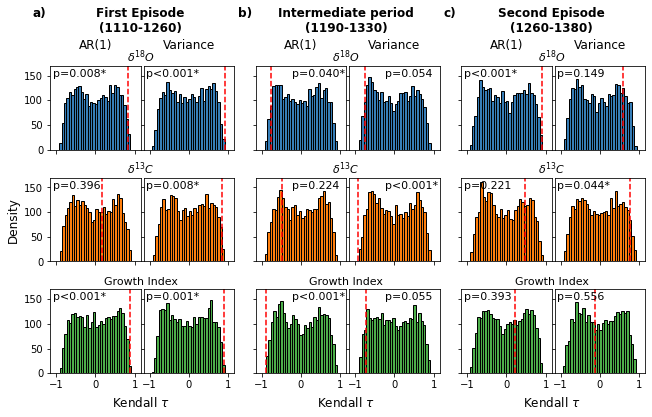

In [37]:
fig = plt.figure(figsize=(12,6),facecolor='white')
gs = gridspec.GridSpec(18, 36, hspace=1)

axes={}
for p,(ep,_) in enumerate(episodes.items()):
    for i,rec in enumerate(rec_names): ## Colormaps
        pad = p - 1
        axes[f'st_ar1_{ep}_{rec}'] = plt.subplot(gs[1+(6*i):6*(i+1),1+p*10+pad:6+p*10+pad])
        axes[f'st_var_{ep}_{rec}'] = plt.subplot(gs[1+(6*i):6*(i+1),6+p*10+pad:11+p*10+pad])

for p,(ep,_) in enumerate(episodes.items()):
    for i,rec in enumerate(rec_names):
        for m in metrics.keys():        
            significance[ep][m].surrog_kendalls[rec].hist(bins=30, ax=axes[f'st_{m}_{ep}_{rec}'],grid=False,edgecolor = "black", color=colors[rec])
            axes[f'st_{m}_{ep}_{rec}'].axvline(significance[ep][m].kendall_coeff[rec],color='r',linestyle='dashed', linewidth=1.5)
            prob = significance[ep][m].pvalue[rec]
            psig = '*' if prob<0.05 else ''
            comp = '<' if prob<=0.001 else '='
            prob = 0.001 if prob==0 else prob
            posp = 0.03 if ep!='int' else 0.4
            axes[f'st_{m}_{ep}_{rec}'].text(posp, 0.87, f'p{comp}{prob:.3f}{psig}', transform=axes[f'st_{m}_{ep}_{rec}'].transAxes, size=11)

## Visual improvements
for ep,iv in episodes.items():
    ep_name = ep_names[ep] +'\n'+ f'({iv[0]}-{iv[1]})'
    axes[f'st_ar1_{ep}_d18O'].text(1, 1.4, ep_name, transform=axes[f'st_ar1_{ep}_d18O'].transAxes, size=12,weight='bold',ha='center')
    axes[f'st_ar1_{ep}_d18O'].text(-0.2, 1.58, {'1':'a)','int':'b)','2':'c)'}[ep], transform=axes[f'st_ar1_{ep}_d18O'].transAxes, size=12,weight='bold')
    axes[f'st_ar1_{ep}_GI'].text(1, -0.4,r'Kendall $\tau$', transform=axes[f'st_ar1_{ep}_GI'].transAxes, size=12,ha='center')
    for metric,mlab in metrics.items():
        axes[f'st_{metric}_{ep}_d18O'].text(0.5, 1.2, mlab, transform=axes[f'st_{metric}_{ep}_d18O'].transAxes, size=12,ha='center')
    for rec,label in labels.items():
        axes[f'st_ar1_{ep}_{rec}'].text(1, 1.05, label, transform=axes[f'st_ar1_{ep}_{rec}'].transAxes, size=11,ha='center')
axes['st_ar1_1_d13C'].set_ylabel('Density',fontsize=12)
### Axes limits
for ax in fig.axes:
    ax.set_xlim(-1.15,1.15)
    ax.set_ylim(0,170)
### Removing ticklabels
for ax in [ax for name_ax,ax in axes.items() if 'GI' not in name_ax]:
    ax.set_xticklabels('');
for ax in [ax for name_ax,ax in axes.items() if 'ar1_1' not in name_ax]:
    ax.set_yticklabels('');
#fig.savefig('img/signif_NIS.png',dpi=300, bbox_inches='tight')

In [41]:
eps = 'Episode'
for i,rec in enumerate(rec_names):    
    tar1,tvar = f'{rec}',''
    for ep,_ in episodes.items():
        eps += f'\t\t\t{ep}\t'
        tar1+= '\t   ar1: tau={:.2f},p={:.3f}'.format(significance[ep]['ar1'].kendall_coeff[rec],significance[ep]['ar1'].pvalue[rec])
        tvar += '\t   var: tau={:.2f},p={:.3f}'.format(significance[ep]['var'].kendall_coeff[rec],significance[ep]['var'].pvalue[rec]) 
    if i ==0:
        print(eps)
    print('-'*(len(tar1)+20))
    print(tar1,tvar,sep='\n')

Episode			1				int				2	
----------------------------------------------------------------------------------------------------
d18O	   ar1: tau=0.84,p=0.008	   ar1: tau=-0.76,p=0.040	   ar1: tau=0.90,p=0.001
	   var: tau=0.93,p=0.000	   var: tau=-0.73,p=0.054	   var: tau=0.58,p=0.149
----------------------------------------------------------------------------------------------------
d13C	   ar1: tau=0.18,p=0.396	   ar1: tau=-0.47,p=0.224	   ar1: tau=0.47,p=0.221
	   var: tau=0.85,p=0.008	   var: tau=-0.94,p=0.000	   var: tau=0.76,p=0.044
--------------------------------------------------------------------------------------------------
GI	   ar1: tau=0.87,p=0.001	   ar1: tau=-0.89,p=0.000	   ar1: tau=0.21,p=0.393
	   var: tau=0.90,p=0.001	   var: tau=-0.73,p=0.055	   var: tau=-0.11,p=0.556


## Robustness of trends to choice of window length and bandwidth

In [49]:
min_wL = 20
max_wL = 100
min_bW = 5
max_bW = 80
res_wL = 2
res_bW = 1
robustness = {}
for ep, iv in episodes.items():
    df_ep = records[(records.index>=iv[0])&(records.index<=iv[1])]
    robustness[ep] = df_ep.robustness(indicators=['ar1','var'],min_wL=min_wL,max_wL=max_wL,min_bW=min_bW,max_bW=max_bW,res_bW=res_bW,res_wL=res_wL)

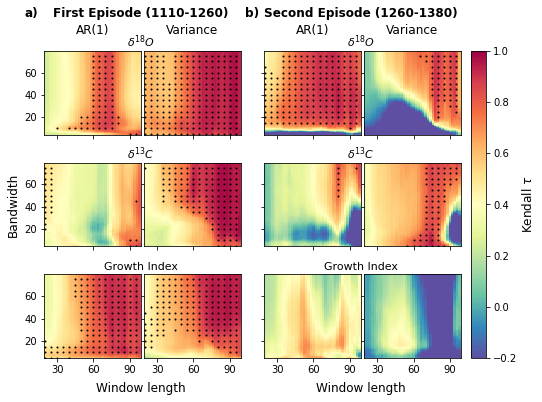

In [50]:
fig = plt.figure(figsize=(9,6),facecolor='white')
gs = gridspec.GridSpec(18, 21, hspace=1)
axes={}
for p,ep in enumerate(['1','2']):
    for i,rec in enumerate(rec_names): ## Axes for the colourmaps
        pad = p - 1
        axes[f'cm_ar1_{ep}_{rec}'] = plt.subplot(gs[1+(6*i):6*(i+1),1+p*10+pad:6+p*10+pad])
        axes[f'cm_var_{ep}_{rec}'] = plt.subplot(gs[1+(6*i):6*(i+1),6+p*10+pad:11+p*10+pad])

### Significant trends over the parameter space
### The p-values were computed with the script ews_NIS_significance_tests.py
bW_vs = np.load('data/signif-tests/bW_vs.npy')
wL_vs = np.load('data/signif-tests/wL_vs.npy')
## Colour maps
for ep in ['1','2']:
    for i,rec in enumerate(rec_names): ## Colormaps
        for m in metrics.keys():
            cmap = axes[f'cm_{m}_{ep}_{rec}'].pcolormesh(robustness[ep][rec][m].columns,robustness[ep][rec][m].index,robustness[ep][rec][m],vmin=-0.2,vmax=1,cmap='Spectral_r', shading='auto')   
            pvals = np.load(f'data/signif-tests/p{m}_{rec}_{ep}.npy')
            pvals_signif = np.where(pvals<=0.05) ## Significance set to p<=0.05
            axes[f'cm_{m}_{ep}_{rec}'].scatter(wL_vs[pvals_signif[1]],bW_vs[pvals_signif[0]],color='k',s=1)
cbar = plt.colorbar(cmap, ax=[ax for k,ax in axes.items() if 'cm' in k],pad=0.02)
cbar.ax.set_ylabel(r'Kendall $\tau$', fontsize=12)
## Visual improvements
for ep in ['1','2']:
    ep_name = ep_names[ep] + f' ({episodes[ep][0]}-{episodes[ep][1]})'
    axes[f'cm_ar1_{ep}_d18O'].text(1, 1.4, ep_name, transform=axes[f'cm_ar1_{ep}_d18O'].transAxes, size=12,weight='bold',ha='center')
    axes[f'cm_ar1_{ep}_d18O'].text(-0.2, 1.4, {'1':'a)','2':'b)'}[ep], transform=axes[f'cm_ar1_{ep}_d18O'].transAxes, size=12,weight='bold')
    axes[f'cm_ar1_{ep}_GI'].text(1, -0.4,'Window length', transform=axes[f'cm_ar1_{ep}_GI'].transAxes, size=12,ha='center')
    for metric,mlab in metrics.items():
        axes[f'cm_{metric}_{ep}_d18O'].text(0.5, 1.2, mlab, transform=axes[f'cm_{metric}_{ep}_d18O'].transAxes, size=12,ha='center')
    for rec,label in labels.items():
        axes[f'cm_ar1_{ep}_{rec}'].text(1, 1.05, label, transform=axes[f'cm_ar1_{ep}_{rec}'].transAxes, size=11,ha='center')
axes['cm_ar1_1_d13C'].set_ylabel('Bandwidth',fontsize=12)

for k,ax in axes.items():
    ax.set_xticks([30,60,90]);
### Removing ticklabels
for ax in [ax for name_ax,ax in axes.items() if 'GI' not in name_ax]:
    ax.set_xticklabels('');
for ax in [ax for name_ax,ax in axes.items() if 'ar1_1' not in name_ax]:
    ax.set_yticklabels('');
#fig.savefig('img/rob_cm_NIS.png',dpi=300, bbox_inches='tight')